# Measurement-induced dephasing on Starmon-5

In [1]:
import numpy as np
import pandas as pd
import qiskit.tools.jupyter
import qiskit.circuit.library.standard_gates as gates
import qiskit.tools.visualization as qvis

from importlib import reload
import inspire_experiments
reload(inspire_experiments)
from inspire_experiments import ExperimentData, inspire_login, get_starmon_status
from inspire_experiments.analysis_tools import *
reload(inspire_experiments.analysis_tools)

# matplotlib.style.use('ggplot')
# matplotlib.style.use('seaborn')
# %matplotlib notebook
%load_ext autoreload
%autoreload 2
%qiskit_version_table

In [2]:
api, backend = inspire_login()
backend.status()

Backend status:  EXECUTION


In [3]:

get_starmon_status(api)

'EXECUTION'

## Readout error correction

In [4]:
def extract_readout_correction(qubit, filename: str="readout_correction"):
    # data_0 = get_json_data(filename.format(qubit) + "_state0" + "_PROB.json")
    # data_1 = get_json_data(filename.format(qubit) + "_state1" + "_PROB.json")
    # print([list(data_0[0].values())[0] - list(data_0[0].values())[1], list(data_1[0].values())[0] - list(data_1[0].values())[1]] )

    data_0 = ExperimentData.get_csv_data(filename + f"_qbs{[qubit]}" + "_testedQb0" + "_state0" + "_RAW.csv", single_qubit=True)
    data_1 = ExperimentData.get_csv_data(filename + f"_qbs{[qubit]}" + "_testedQb0" + "_state1" + "_RAW.csv", single_qubit=True)
    # print(data_0, data_1)

    # convert 0/1 into +1/-1 operator expectation values
    msmt_0 = 1 - 2*data_0
    msmt_1 = 1 - 2*data_1

    m_avg = np.array([msmt_0.mean(), msmt_1.mean()])
    print("measured Z exp val: ", m_avg)
    beta = 0.5 * np.dot(np.array([[1,1], [1,-1]]), m_avg)
    print("beta vector: ", beta)

    # m_corr = beta[0] + beta[1] * msmt_1.mean()
    # print("corrected averages: ", m_corr)
    Z_corr = (m_avg - beta[0])/beta[1]
    print("corrected Z exp val: ", Z_corr)

    return beta

In [5]:
beta_qb2 = extract_readout_correction(2)
print(beta_qb2)

measured Z exp val:  [ 0.97351074 -0.94067383]
beta vector:  [0.01641846 0.95709229]
corrected Z exp val:  [ 1. -1.]
[0.01641846 0.95709229]


In [6]:
beta_qb3 = extract_readout_correction(3)
print(beta_qb3)

measured Z exp val:  [ 0.97363281 -0.91699219]
beta vector:  [0.02832031 0.9453125 ]
corrected Z exp val:  [ 1. -1.]
[0.02832031 0.9453125 ]


### using pycqed method to extract readout correction

In [7]:
tomo_qubits = [3]
shots_dict = {qb: {} for qb in tomo_qubits}
for state in [''.join(s) for s in it.product(['0', '1'], repeat=len(tomo_qubits))]:
    print(state)
    bitstrings = ExperimentData.get_csv_data(f"readout_correction_qbs{tomo_qubits}_testedQb0_state{state}_RAW.csv")
    pprint(bitstrings)
    for qb in shots_dict.keys():
        shots_dict[qb][state] = 1 - 2*np.array(list(map(lambda s: int(s[-1-qb]), bitstrings)))
shots_dict

0
array(['00000', '00000', '00000', ..., '00000', '01000', '00000'],
      dtype='<U5')
1
array(['01000', '01000', '01000', ..., '01000', '01000', '01000'],
      dtype='<U5')


{3: {'0': array([ 1,  1,  1, ...,  1, -1,  1]),
  '1': array([-1, -1, -1, ..., -1, -1, -1])}}

In [8]:
beta = get_beta_matrix(shots_dict, 1)
beta

{'Z': array([0.02832031, 0.9453125 ])}

In [11]:
np.isclose(beta_qb3, beta['Z'])

array([ True,  True])

## Tomography analysis

In [8]:
def analyze_msmt_induced_dephasing_tomography(
        filename: str,
        readout_correction: List[float],
        mask_value: float = None,
        sim_msmt: bool = False
):
    tomo_keys = ['X', 'Y', 'Z']
    tomo_data = dict.fromkeys(tomo_keys, None)
    expvals_raw = dict.fromkeys(tomo_keys)
    expvals_corr = dict.fromkeys(tomo_keys)
    p_frac = 1

    for m in tomo_data.keys():
        data = ExperimentData.get_csv_data(filename + f"_M{m}" + "_RAW.csv", single_qubit=True)
        # print(filename, data)
        # convert 0/1 into +1/-1 operator expectation values
        if sim_msmt:
            tomo_data[m] = 1 - 2*data
        else:
            # use only last msmt to discard data of inducing qubit
            # (if multiple msmts happen in sequence, each gets its own row in raw data matrix)
            if mask_value is not None:
                mask_bits = data[0]
                mask = mask_bits == mask_value
                tomo_data[m] = 1 - 2*data[1][mask]
                p_frac = mask.sum()/len(mask_bits)
            else:
                tomo_data[m] = 1 - 2*data[-1]

        expvals_raw[m] = tomo_data[m].mean()
        expvals_corr[m] = (expvals_raw[m] - readout_correction[0]) / readout_correction[1]

    # print(tomo_data)
    # print(expvals_raw)
    # print(expvals_corr)

    rho = 0.5 * (gates.IGate().to_matrix()
                 + expvals_corr['X'] * gates.XGate().to_matrix()
                 + expvals_corr['Y'] * gates.YGate().to_matrix()
                 + expvals_corr['Z'] * gates.ZGate().to_matrix()
                 )
    return expvals_corr, rho, p_frac

12:48:10 - inspire_experiments.data_utils:INFO - Saving figure <msmt_induced_dephasing_qbs(2, 1)_testedQb0_eqTomo - Figure(1200x1000)> in ./plots/
/media/redwombat/DataNVME/Sciebo/Uni/TUDELFT/QuantumInspire/Starmon-5/src/inspire-experiments/inspire_experiments/data_utils.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(directory / Path(name + "_PLOT.png"), format='png', dpi=200)
/media/redwombat/DataNVME/Sciebo/Uni/TUDELFT/QuantumInspire/Starmon-5/src/inspire-experiments/inspire_experiments/data_utils.py:129: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(directory / Path(name + "_PLOT.png"), format='png', dpi=200)
12:48:10 - inspire_experiments.data_utils:INFO - Saving figure <msmt_induced_dephasing_qbs(2, 1)_testedQb0_eqTomo_EXPVALS - Figure(720x480)> in ./plots/
12:48:10 - inspire_experiments.data_util

0.533447265625 0.466552734375


/media/redwombat/DataNVME/Sciebo/Uni/TUDELFT/QuantumInspire/Starmon-5/src/inspire-experiments/inspire_experiments/data_utils.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(directory / Path(name + "_PLOT.png"), format='png', dpi=200)
/media/redwombat/DataNVME/Sciebo/Uni/TUDELFT/QuantumInspire/Starmon-5/src/inspire-experiments/inspire_experiments/data_utils.py:129: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(directory / Path(name + "_PLOT.png"), format='png', dpi=200)
12:48:12 - inspire_experiments.data_utils:INFO - Saving figure <msmt_induced_dephasing_qbs(2, 1)_testedQb+_eqTomo_EXPVALS - Figure(720x480)> in ./plots/
12:48:12 - inspire_experiments.data_utils:INFO - Saving figure <msmt_induced_dephasing_qbs(2, 3)_testedQb0_eqTomo - Figure(1200x1000)> in ./plots/
/media/redwombat/DataNVME/Sciebo/Uni/TUD

0.5399169921875 0.4600830078125


/media/redwombat/DataNVME/Sciebo/Uni/TUDELFT/QuantumInspire/Starmon-5/src/inspire-experiments/inspire_experiments/data_utils.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(directory / Path(name + "_PLOT.png"), format='png', dpi=200)
/media/redwombat/DataNVME/Sciebo/Uni/TUDELFT/QuantumInspire/Starmon-5/src/inspire-experiments/inspire_experiments/data_utils.py:129: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(directory / Path(name + "_PLOT.png"), format='png', dpi=200)
12:48:14 - inspire_experiments.data_utils:INFO - Saving figure <msmt_induced_dephasing_qbs(2, 3)_testedQb+_eqTomo_EXPVALS - Figure(720x480)> in ./plots/
12:48:14 - inspire_experiments.data_utils:INFO - Saving figure <msmt_induced_dephasing_qbs(2, None)_eqTomo - Figure(1200x1000)> in ./plots/
/media/redwombat/DataNVME/Sciebo/Uni/TUDELFT/Qu

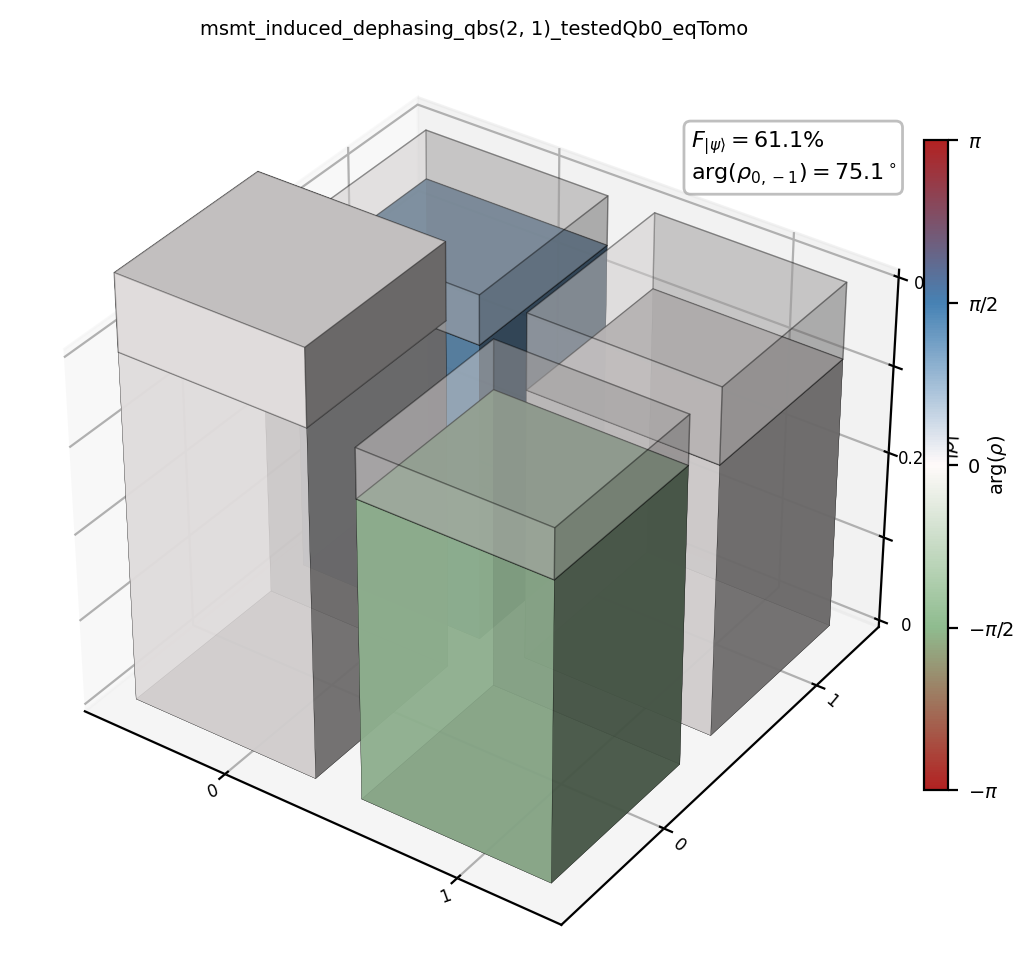

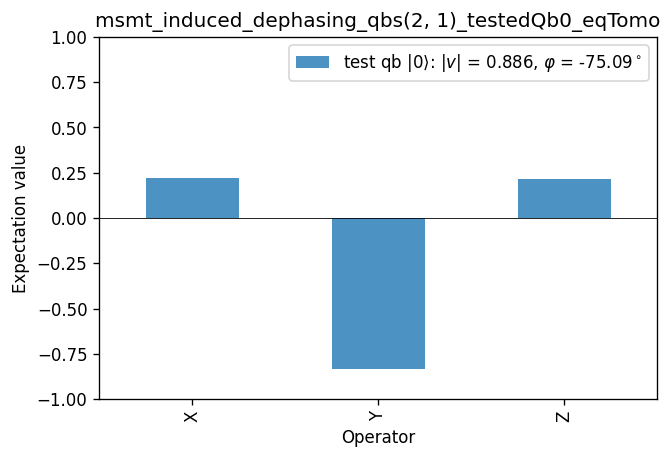

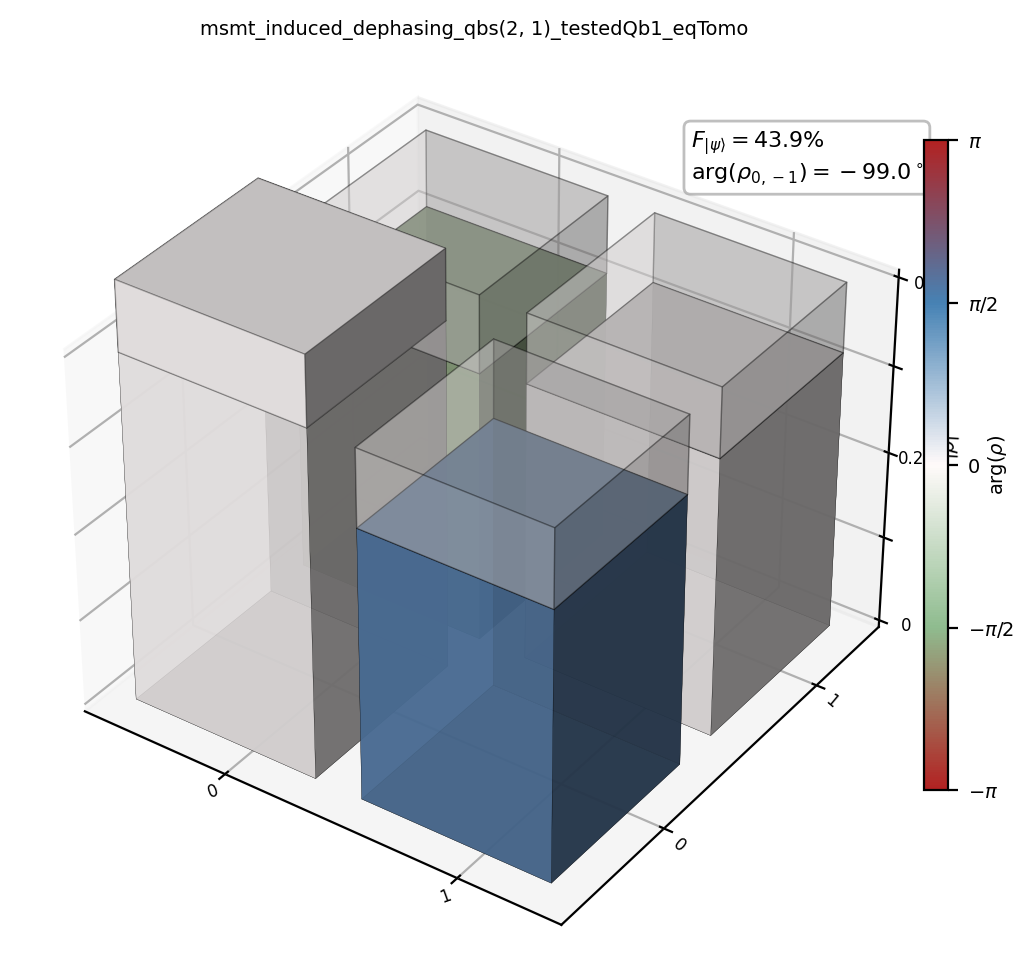

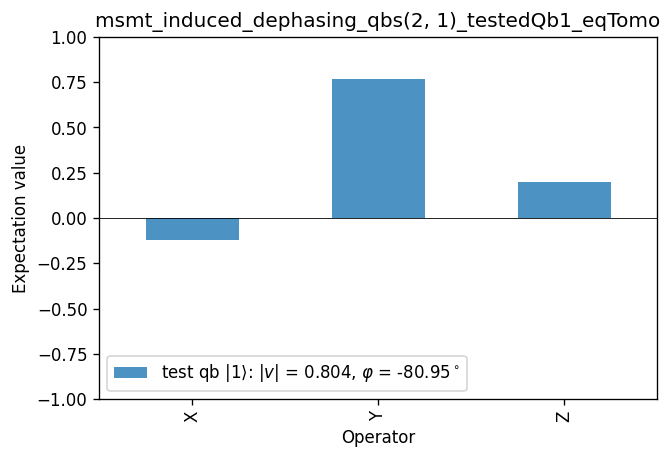

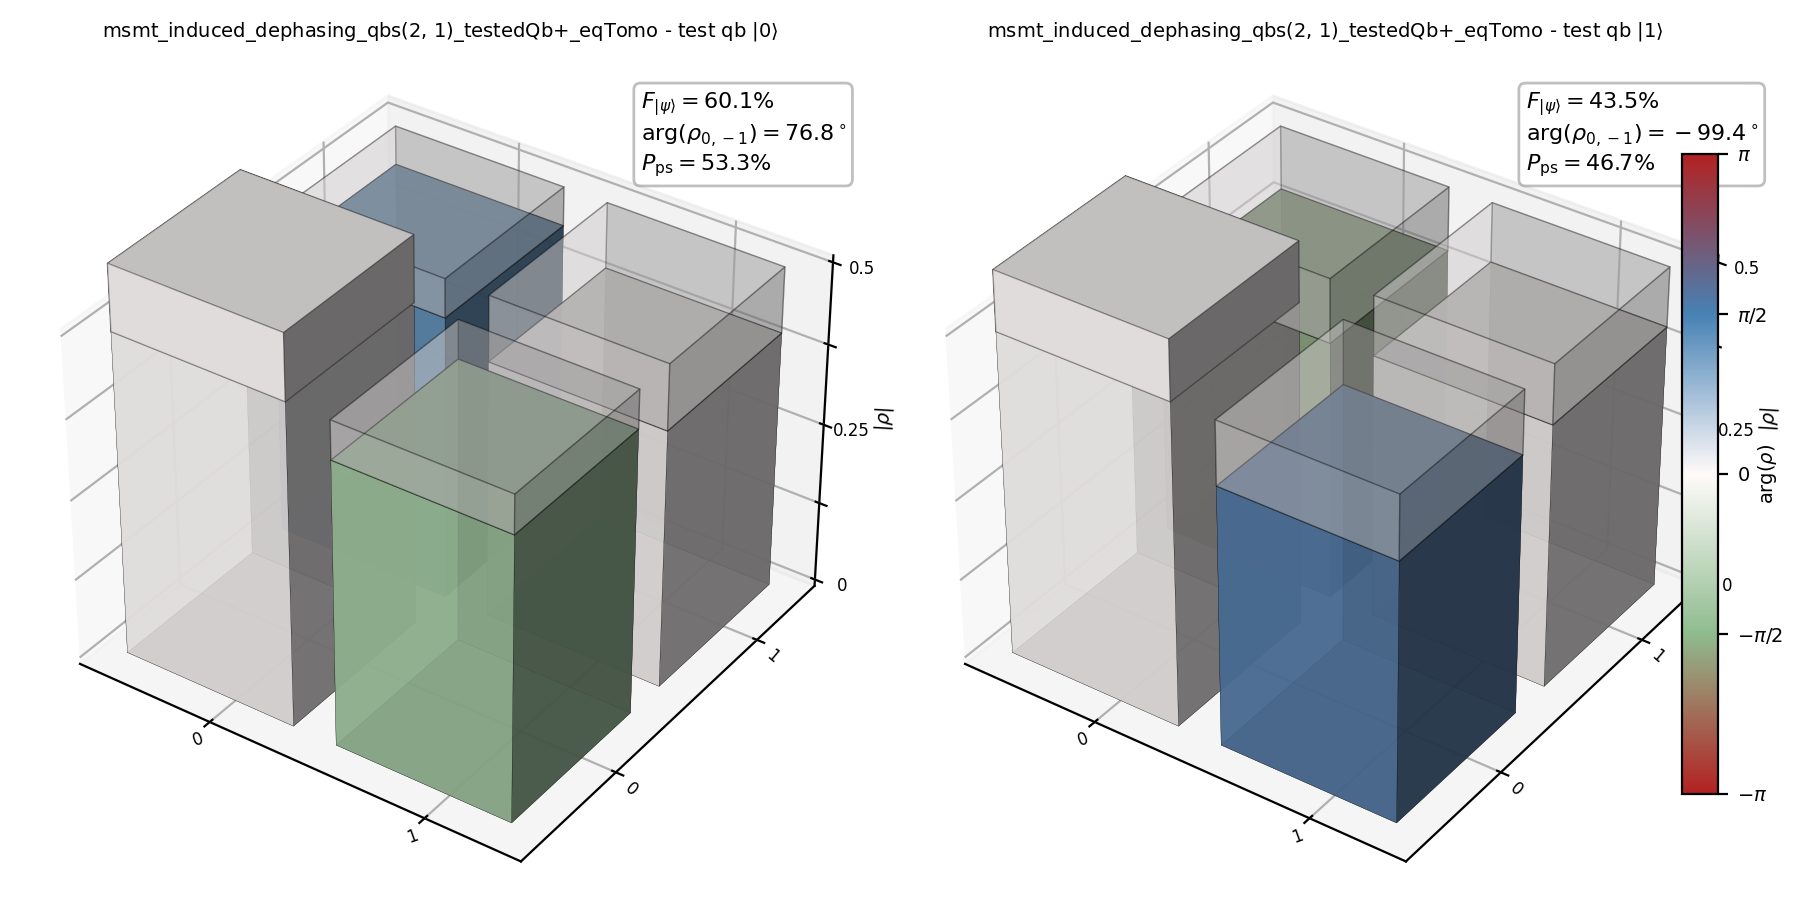

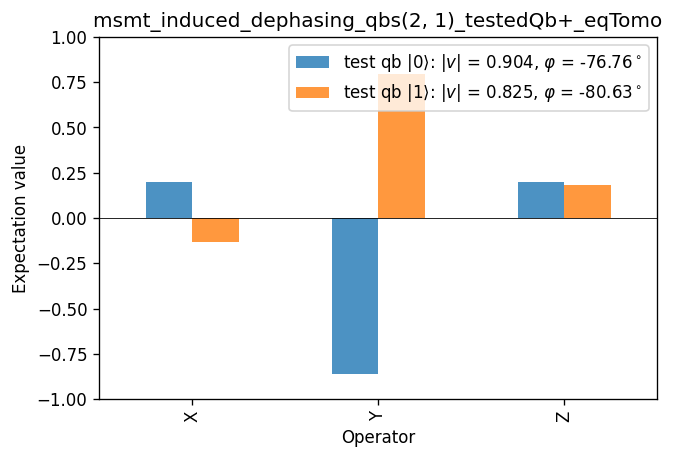

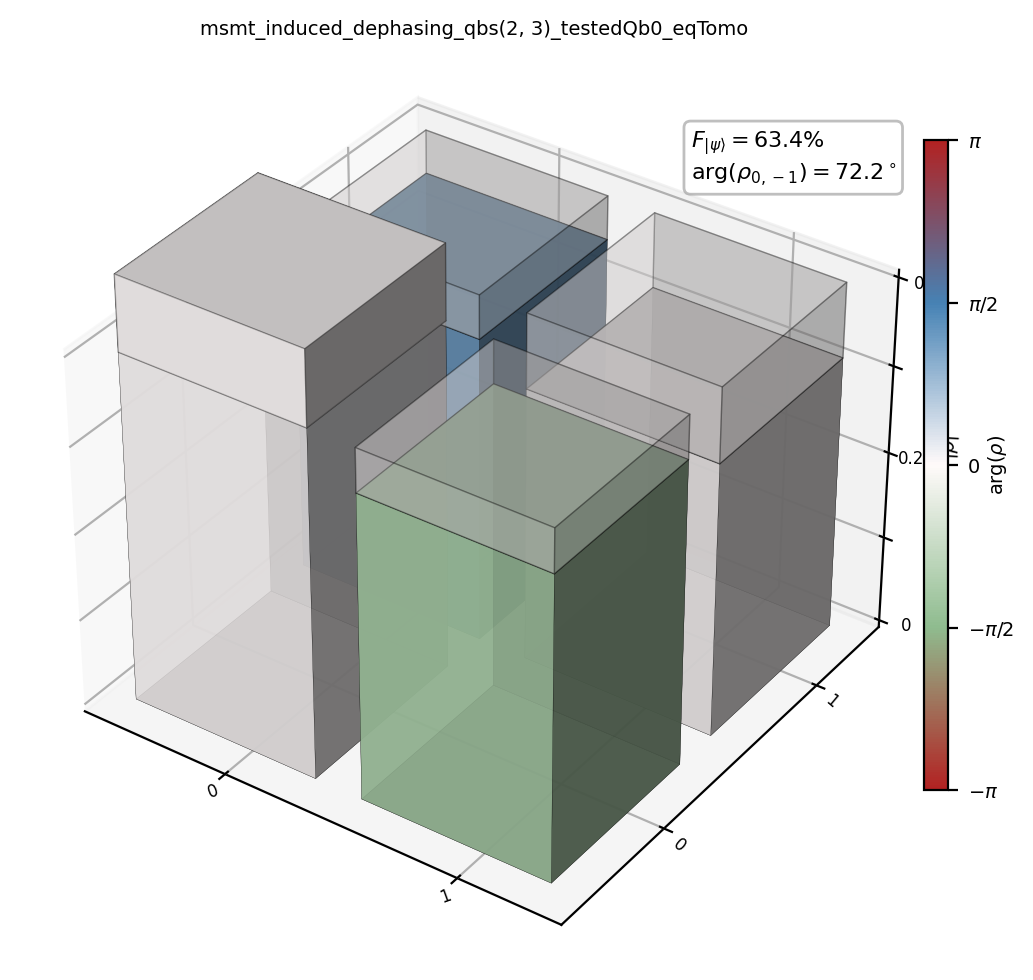

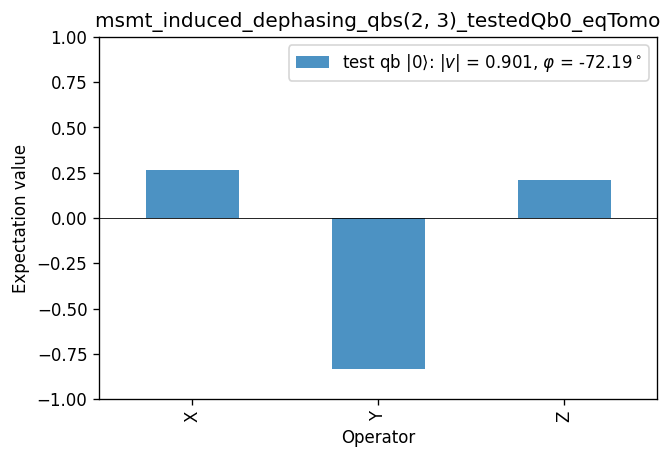

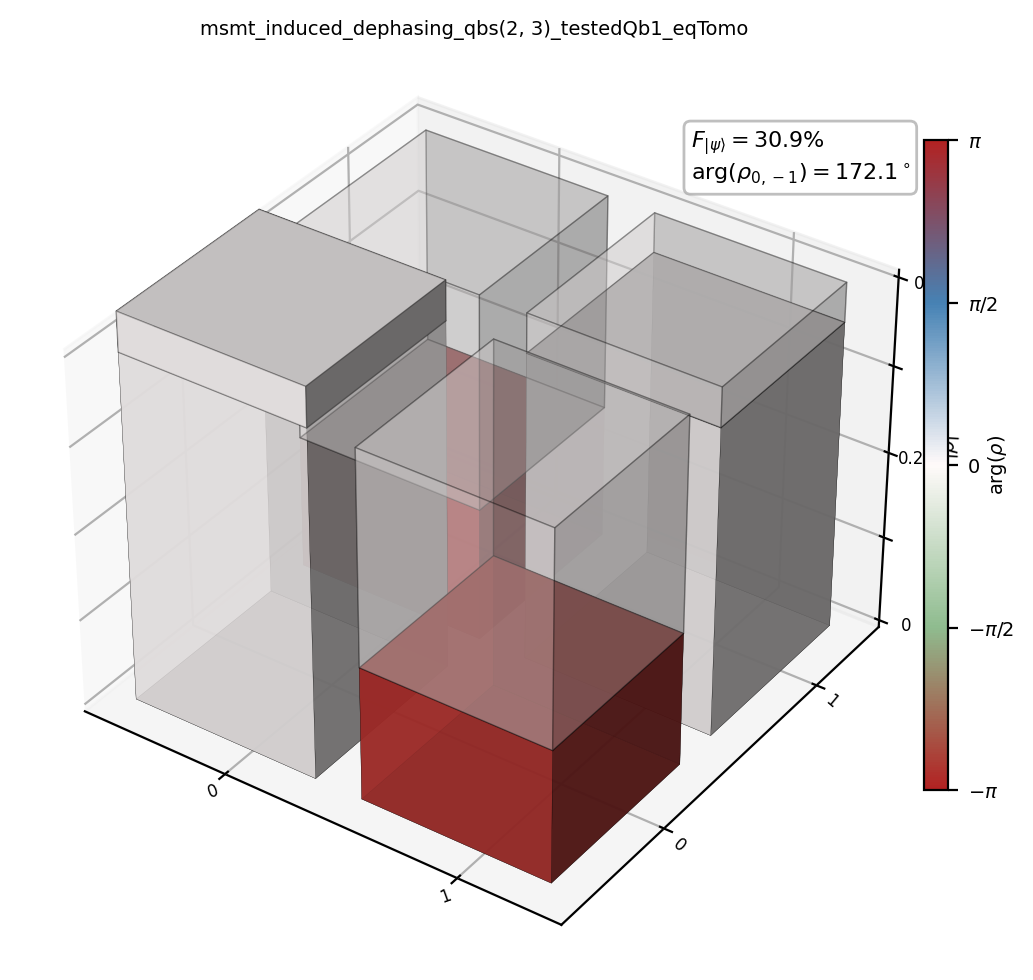

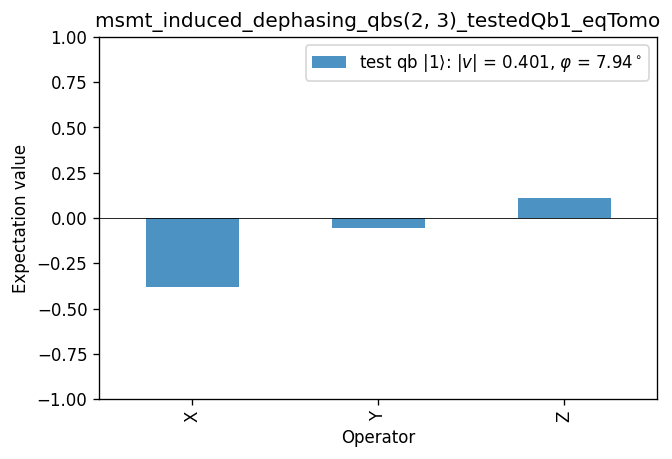

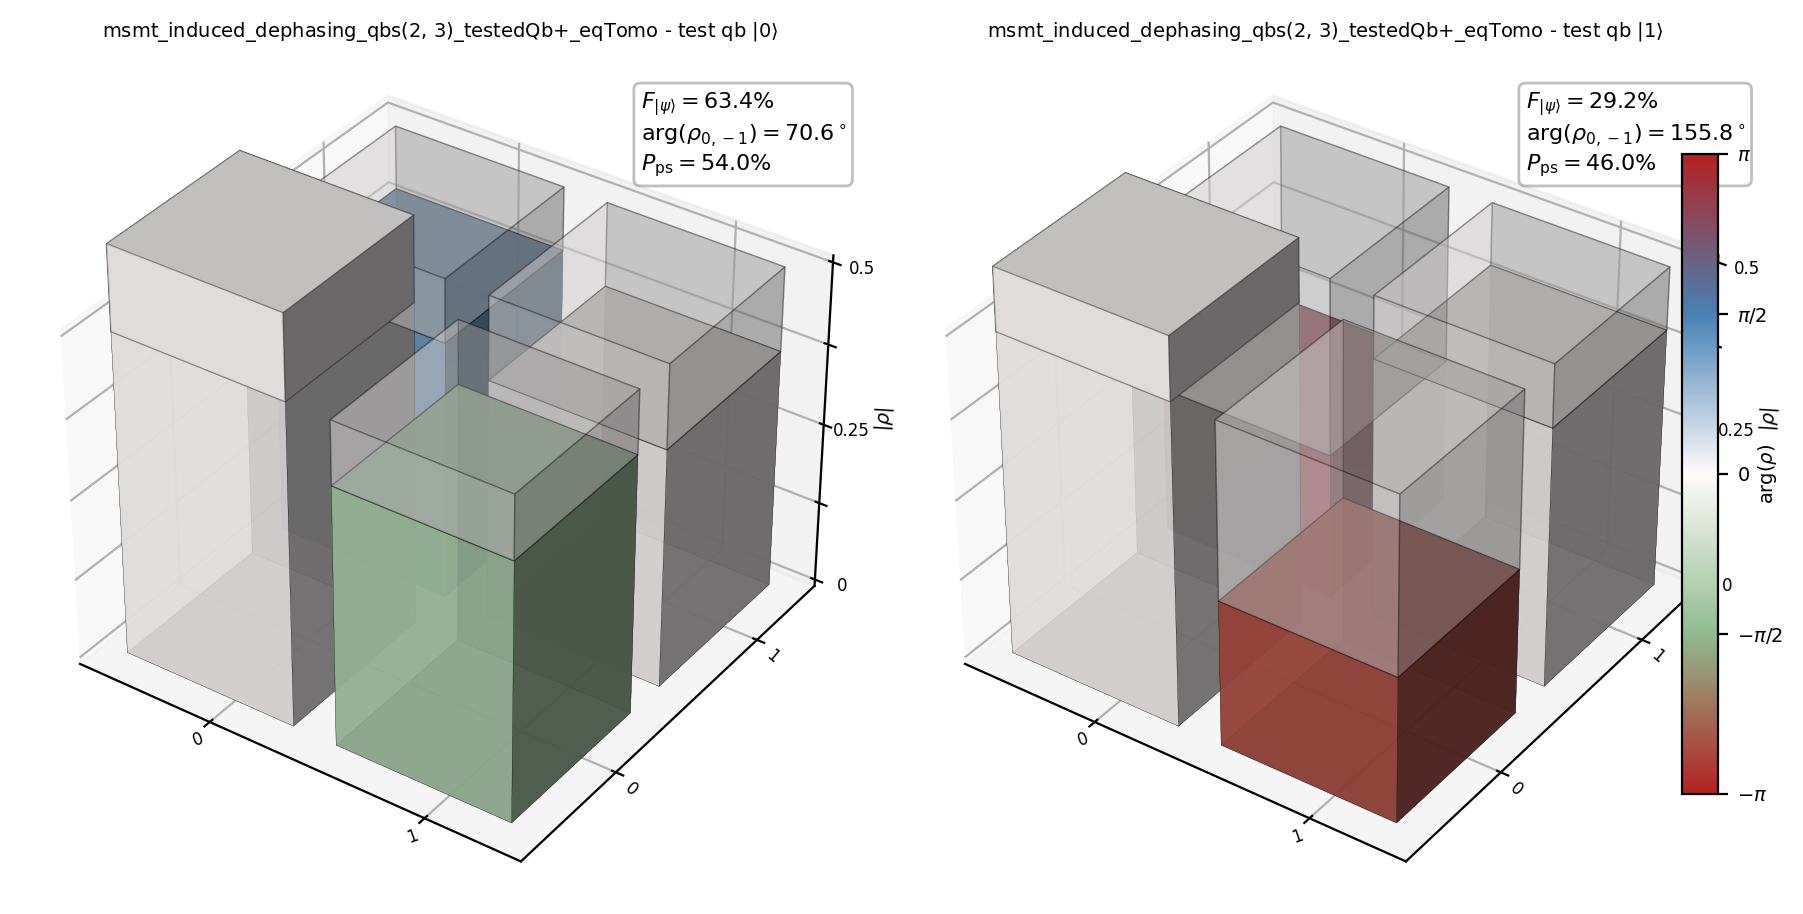

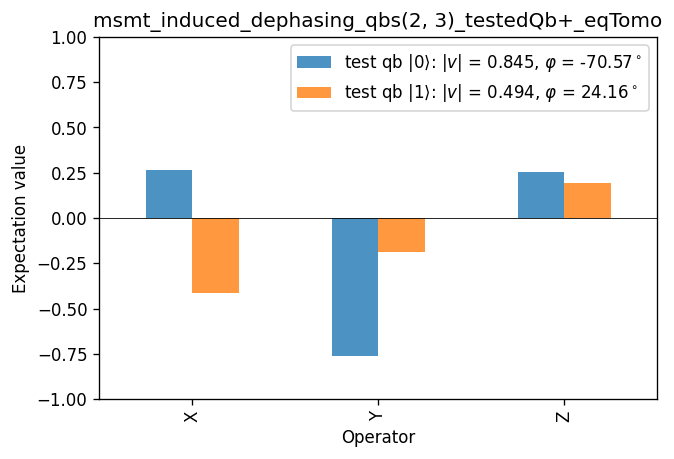

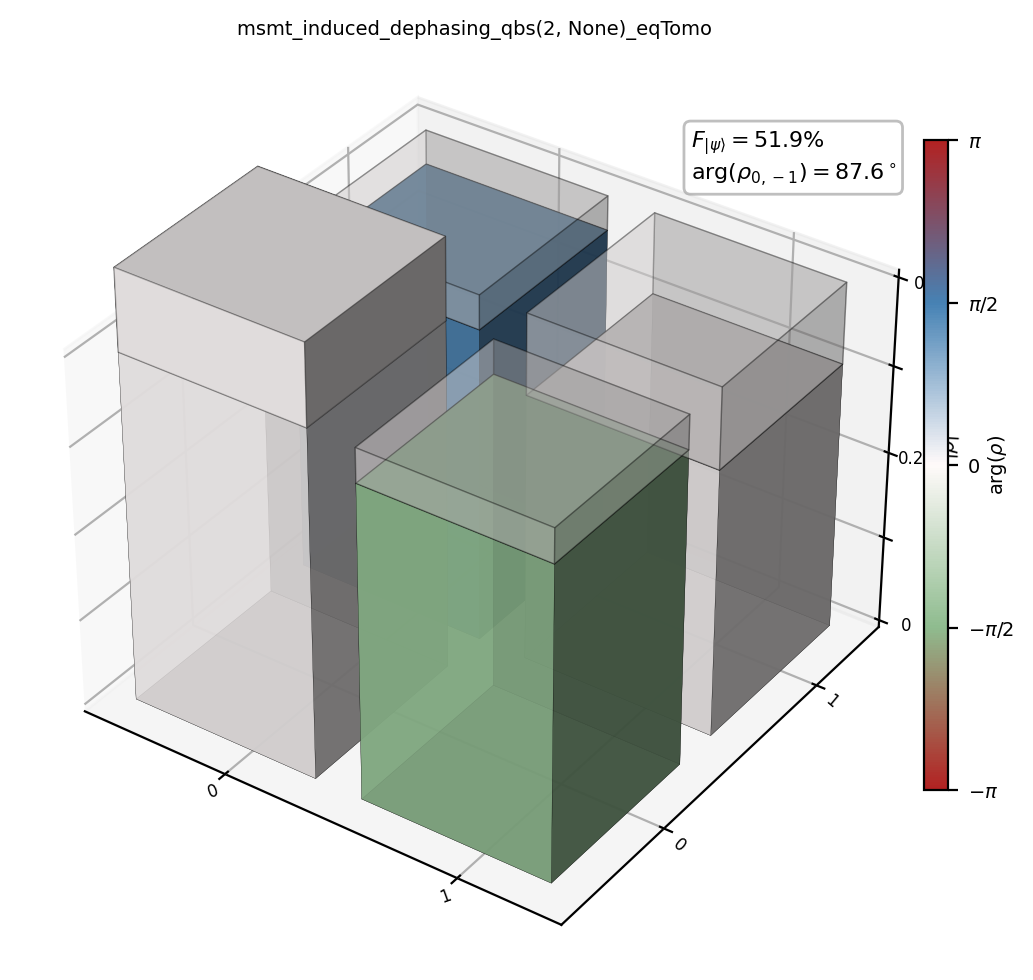

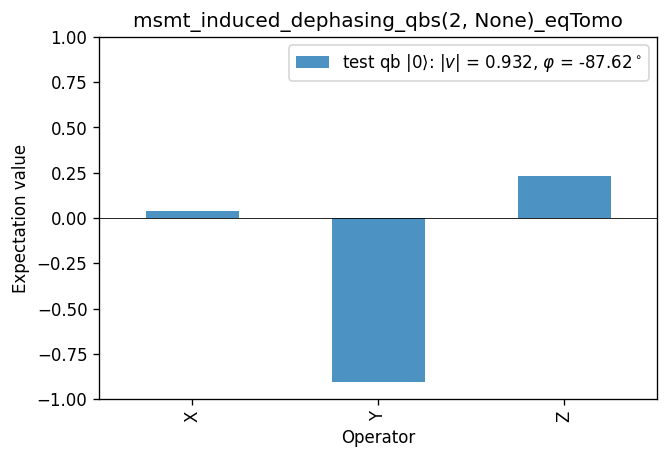

In [11]:
pairs = [(2,1), (2,3), (2, None)]
# pairs = [(3,2), (3, None)]
states = ['0', '1', '+']
# pairs = [(3,2)]
# states = ['+']
correction = beta_qb2

for pair in pairs:
    for state in states:
        exp_name = "msmt_induced_dephasing_qbs" + f"{pair}"
        exp_name = exp_name + f"_testedQb{state}" if pair[1] is not None else exp_name
        exp_name += "_eqTomo"

        if state == '+':
            expvals0, rho0, p_frac0 = analyze_msmt_induced_dephasing_tomography(exp_name, readout_correction=correction, mask_value=0, sim_msmt=False if pair[1] is not None else True)
            expvals1, rho1, p_frac1 = analyze_msmt_induced_dephasing_tomography(exp_name, readout_correction=correction, mask_value=1, sim_msmt=False if pair[1] is not None else True)
            print(p_frac0, p_frac1)

            rho_model = np.full(rho0.shape, 0.5)
            fid_0 = fidelity(rho0, rho_model)
            fid_1 = fidelity(rho1, rho_model)
            angle_0 = np.angle(rho0[0,-1], deg=True)
            angle_1 = np.angle(rho1[0,-1], deg=True)

            fig = plot_density_matrix(
                rho=rho0, rho_id=rho_model, angle=angle_0, fidelity=fid_0, ps_frac=p_frac0, title=exp_name + r' - test qb $|0\rangle$',
                rho2=rho1, rho2_id=rho_model, angle2=angle_1, fidelity2=fid_1, ps_frac2=p_frac1, title2=exp_name + r' - test qb $|1\rangle$'
            )
            ExperimentData.save_fig(fig, exp_name)

            df = pd.DataFrame({r'test qb $|0\rangle$': expvals0, r'test qb $|1\rangle$': expvals1})
            df.loc[r'$|v|$'] = np.sqrt((df**2).sum()).values
            df.loc[r'$\varphi$'] = np.rad2deg(np.arctan(df.loc['Y']/df.loc['X'])).values
            # df = pd.concat([df, pd.DataFrame({col: np.sqrt((df[col]**2).sum()) for col in df}, index=[r'$|v|$'])])
            # df = pd.concat([df, pd.DataFrame(np.rad2deg(np.arctan(df.loc['X']/df.loc['Y'])).values, index=[r'$\varphi$'], columns=df.columns)])
            # df = pd.concat([df, pd.DataFrame(np.sqrt((df**2).sum()).values, index=[r'$|v|$'], columns=df.columns)])
            # df = pd.concat([df, pd.Series(np.rad2deg(np.arctan(df.loc['X']/df.loc['Y'])), name=r'$\varphi$', index=df.columns)], ignore_index=False)

            fig2, _ = plot_pauli_exp_values(df, title=exp_name)
            ExperimentData.save_fig(fig2, exp_name + "_EXPVALS")
        else:
            expvals, rho, p_frac = analyze_msmt_induced_dephasing_tomography(exp_name, readout_correction=correction, sim_msmt=False if pair[1] is not None else True)
            rho_model = np.full(rho.shape, 0.5)
            fid_0 = fidelity(rho, rho_model)
            angle_01 = np.angle(rho[0,-1], deg=True) #*180/np.pi
            fig = plot_density_matrix(rho=rho, rho_id=rho_model, angle=angle_01, fidelity=fid_0, title=exp_name)
            ExperimentData.save_fig(fig, exp_name)

            df = pd.DataFrame({rf'test qb $|{state}\rangle$': expvals})
            df.loc[r'$|v|$'] = np.sqrt((df**2).sum()).values
            df.loc[r'$\varphi$'] = np.rad2deg(np.arctan(df.loc['Y']/df.loc['X'])).values

            fig2, _ = plot_pauli_exp_values(df, title=exp_name)
            ExperimentData.save_fig(fig2, exp_name + "_EXPVALS")

        if pair[1] is None:
            break

In [158]:
list(list(df[-2:].iteritems())[0][1].iteritems())

[('$|v|$', 0.8716436676513459), ('$\\varphi$', -61.268695485836126)]

In [155]:
df[-2:]

,test qb $|0\rangle$,test qb $|1\rangle$
$|v|$,0.871644,0.662636
$\varphi$,-61.268695,-81.810538


In [126]:
pd.concat([df, pd.DataFrame(np.sqrt((df**2).sum()).values, index=[r'$|v|$'], columns=df.columns)])


ValueError: Shape of passed values is (2, 1), indices imply (1, 2)

In [118]:
pd.DataFrame(np.sqrt((df**2).sum()), columns=df.columns, index=['e'])

ValueError: Shape of passed values is (1, 1), indices imply (1, 2)

In [100]:
np.rad2deg(np.arctan(df.loc['X']/df.loc['Y'])).values

array([-28.73130451,  -8.18946197])

### using pycqed method for tomography analysis to compare both results

In [14]:
# pairs = [(2,1), (2,3), (2, None)]
pairs = [(3,2)] #, (3, None)]
states = ['1'] #, '1', '+']

for pair in pairs:
    for state in states:
        exp_name = "msmt_induced_dephasing_qbs" + f"{pair}"
        exp_name = exp_name + f"_testedQb{state}" if pair[1] is not None else exp_name
        exp_name += "_eqTomo"
        expvals, rho = analyze_msmt_induced_dephasing_tomography(exp_name, readout_correction=beta_qb3)
        # R_0 = np.zeros(rho.shape)
        # R_0[-1,-1] = 1.0

        rho0 = np.full(rho.shape, 0.5)
        fid_0 = fidelity(rho, rho0)
        angle_01 = np.angle(rho[0,1], deg=True) #*180/np.pi
        fig = plot_density_matrix(rho, rho_id=rho0, angle=angle_01, fidelity=fid_0,
                                  title=exp_name)
        # ExperimentData.save_fig(fig, exp_name)

ValueError: too many values to unpack (expected 2)

In [51]:
# masks_0 = np.empty((len(gen_gate_order(2)), 2**14))
# masks_1 = np.empty((len(gen_gate_order(2)), 2**14))
gate_order = gen_gate_order(1)
masks_0 = [None] * len(gate_order)
masks_1 = [None] * len(gate_order)
pair = pairs[0]
tomo_qubits = [pairs[0][0]] #[3]
state = states[0]

tomo_shots_dict = {qb: {} for qb in tomo_qubits}
sim_msmt = False


for i, tomo_state in enumerate(gate_order):
    print(tomo_state)
    exp_name = "msmt_induced_dephasing_qbs" + f"{pair}"
    exp_name = exp_name + f"_testedQb{state}" if pair[1] is not None else exp_name
    exp_name += f"_eqTomo_M{tomo_state}"
    bitstrings = ExperimentData.get_csv_data(exp_name + "_RAW.csv")
    # print(bitstrings)
    if sim_msmt:
        # for simultaneous msmt
        mask_bits = bitstrings
        tomo_bits = bitstrings
    else:
        # for sequential msmt
        mask_bits = bitstrings[0]
        tomo_bits = bitstrings[1]

    # create masks for postselection on state of middle (ancilla) qubit
    masks_0[i] = np.where(np.array(list(map(lambda s: int(s[pair[1]]), mask_bits))) == 0, 1, np.nan)
    masks_1[i] = np.where(np.array(list(map(lambda s: int(s[pair[1]]), mask_bits))) == 1, 1, np.nan)

    # create dict for shots by qubit, per tomo_state
    for qb in tomo_qubits: # shots_dict.keys():
        tomo_shots_dict[qb][tomo_state] = 1 - 2*np.array(list(map(lambda s: int(s[-1-qb]), tomo_bits)))

tomo_shots_dict

Z
X
Y


{3: {'Z': array([-1,  1,  1, ..., -1,  1,  1]),
  'X': array([ 1, -1, -1, ..., -1,  1,  1]),
  'Y': array([-1, -1, -1, ..., -1, -1, -1])}}

In [40]:
np.array(masks_0).all()

True

In [52]:
tomo_shots_dict[3]['Y'].sum()

-9752

In [53]:
pauli_terms, rho_comp, p_frac = get_pauli_expectation_values(tomo_shots_dict, beta, gate_order, mask=masks_1) #np.ones(len(tomo_shots_dict[3]['Z']), dtype=int))

{'I': 1, 'Z': 1}
[-1  1  1 ... -1  1  1] [-1.  1.  1. ... -1.  1.  1.]
{'I': 1, 'X': 1}
[ 1 -1 -1 ... -1  1  1] [ 1. -1. -1. ... -1.  1.  1.]
{'I': 1, 'Y': 1}
[-1 -1 -1 ... -1 -1 -1] [-1. -1. -1. ... -1. -1. -1.]


In [54]:
p_frac

{'I': 0.96966552734375,
 'X': 0.97137451171875,
 'Y': 0.96966552734375,
 'Z': 0.97015380859375}

In [55]:
pauli_terms

{'I': 1.0,
 'X': 0.039634174838956024,
 'Y': -0.6615265638988578,
 'Z': 0.11798742522597946}

In [84]:
expvals

{'_MX': 0.04816632231404959,
 '_MY': -0.6596074380165289,
 '_MZ': 0.12357954545454546}

array([[0.55899371+0.j        , 0.01981709+0.33076328j],
       [0.01981709-0.33076328j, 0.44100629+0.j        ]])

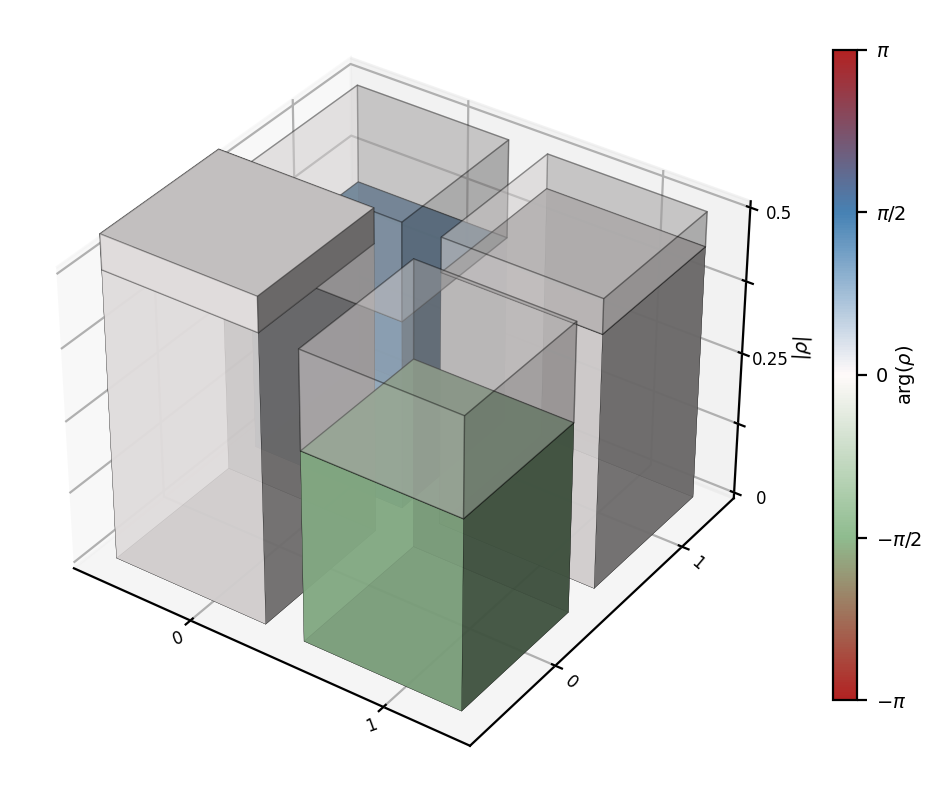

In [56]:
plot_density_matrix(rho_comp, rho_id=rho0)
rho_comp

array([[0.56178977+0.j        , 0.02408316+0.32980372j],
       [0.02408316-0.32980372j, 0.43821023+0.j        ]])

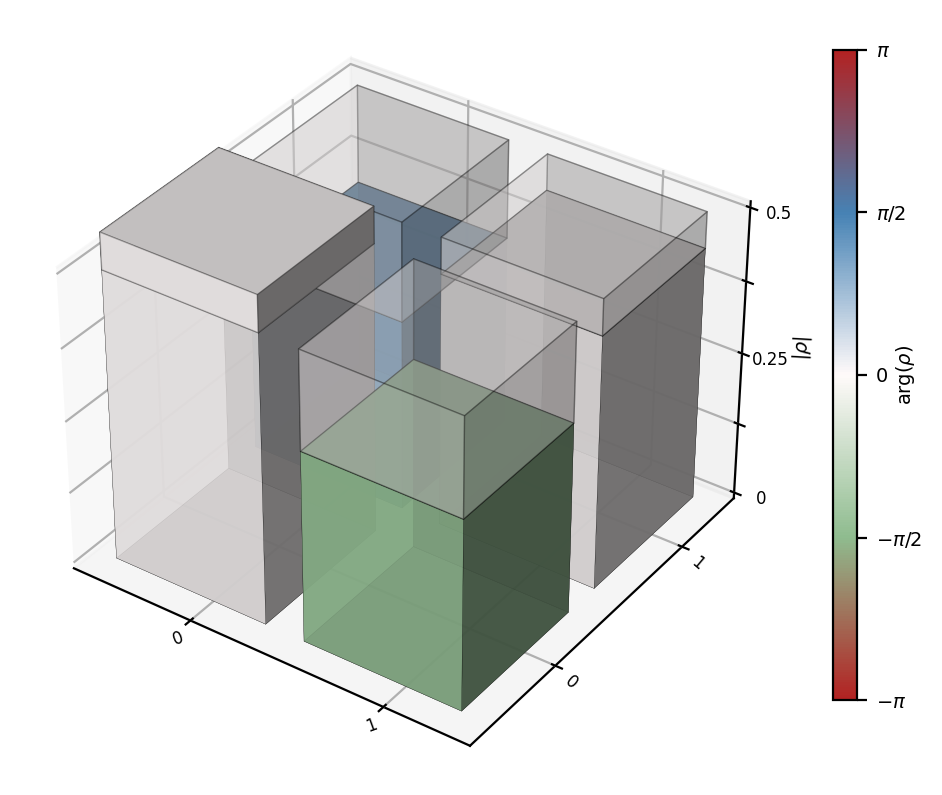

In [57]:
plot_density_matrix(rho, rho_id=rho0)
rho


In [61]:
np.isclose(rho, rho_comp, atol=0.01)


array([[ True,  True],
       [ True,  True]])

array([[ 0.00279606+0.j        ,  0.00426607-0.00095956j],
       [ 0.00426607+0.00095956j, -0.00279606+0.j        ]])

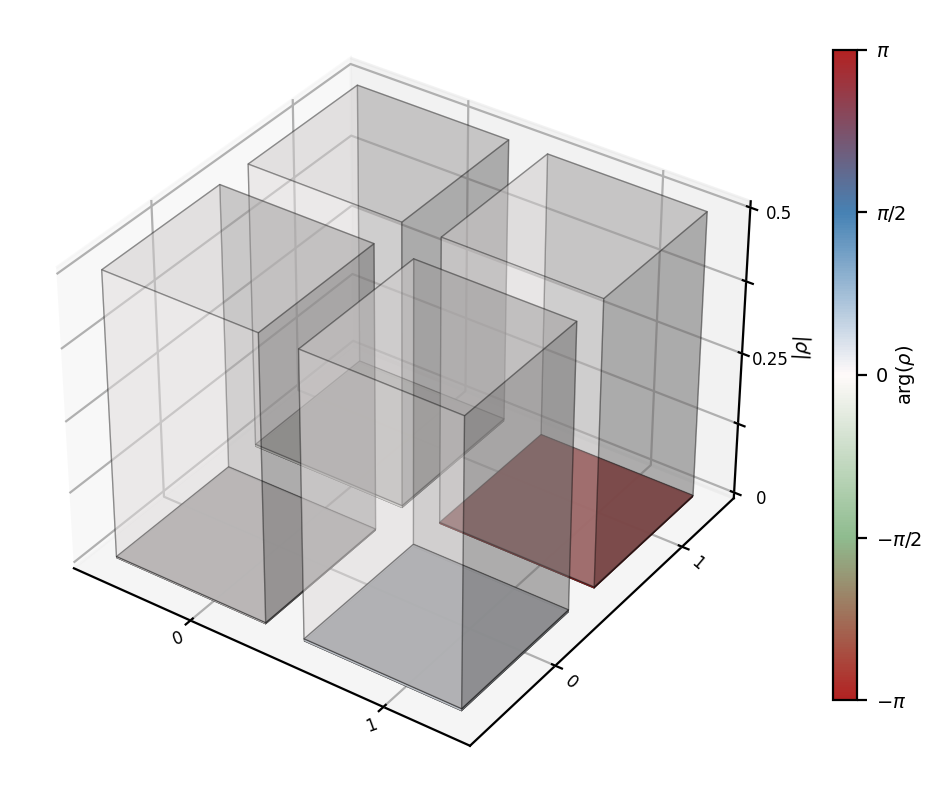

In [66]:
plot_density_matrix(rho-rho_comp, rho_id=rho0)
rho-rho_comp


[Text(0, 0.5, 'Expectation value'),
 Text(0.5, 0, 'Operator'),
 Text(0.5, 1.0, 'msmt_induced_dephasing_qbs(3, 2)_testedQb1_eqTomo_MY')]

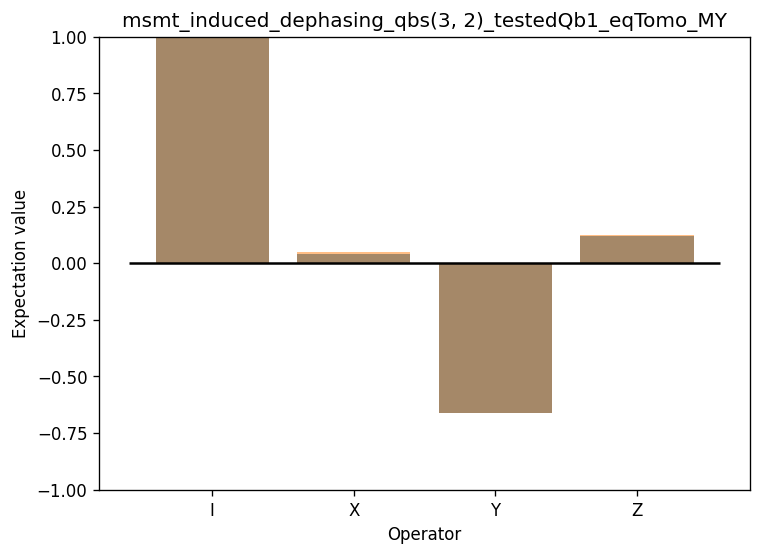

In [104]:
fig, ax = plt.subplots(figsize=(7,5), dpi=120)
ax.bar(pauli_terms.keys(), pauli_terms.values(), alpha=0.8)
ax.bar(pauli_terms.keys(), [1, *expvals.values()], alpha=0.5)
ax.hlines(0, *ax.get_xlim(), 'k')
ax.set_ylim(-1, 1)
ax.set(ylabel="Expectation value", xlabel="Operator", title=exp_name)


In [146]:
(np.array(list(expvals.values()))**2).sum()


0.867780533073387

,manual
_MX,0.025439
_MY,-0.925749
_MZ,0.220300


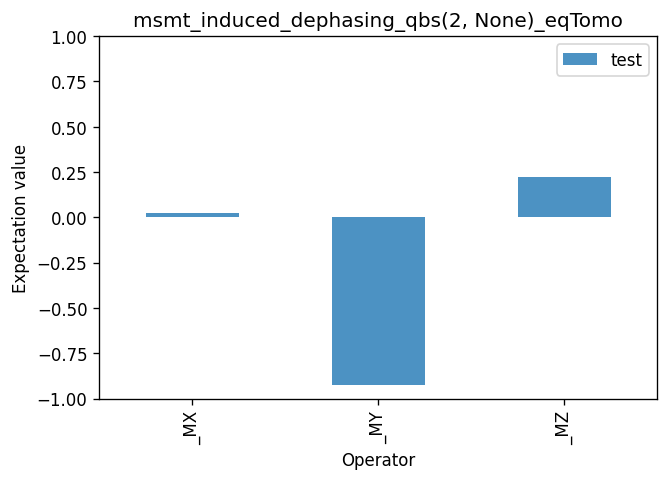

In [29]:
# df = pd.DataFrame({'manual': {k: expvals[f'_M{k}'] for k in list(pauli_terms.keys())[1:]}, 'pycqed': pauli_terms})
df = pd.DataFrame({'manual': {k: expvals[k] for k in list(expvals.keys())}})
# df.drop('I', inplace=True)
ax = df.plot.bar(alpha=0.8, figsize=(6,4))
ax.legend(["test"])
ax.hlines(0, *ax.get_xlim(), 'k')
ax.set_ylim(-1, 1)
ax.set(ylabel="Expectation value", xlabel="Operator", title=exp_name)
ax.get_figure().set_dpi(120)
df


In [168]:

for x in df.columns:
    print((df[x]**2).sum())


0.45267387094674194
0.45310929507045056
